# Script correlaciones
#### Con foco en el centro de Argentina, se correlaciona la precipitación mensual acumulada promediada espacialmente en esa región con otras variables a nivel global:
#### 1. Temperatura en la superficie del mar (SST)
#### 2. Altura geopotencial a 200 hPa, 500 hPa y 850 hPa (GEOP)
#### 3. Presión a nivel medio del mar (MSLP)

## Librerias

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
import cartopy.crs as ccrs	
import cartopy.feature 	
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib
import matplotlib.path as mpath
from scipy import stats # LLamo a la fun stats de scipy 

## Funciones

In [2]:
def xr_corr(dict3D, dict1D):
    
    #Inicializo lista vacia
    corrs=[]
    
    for key in KEYS:
        
        ds3D=dict3D[key]
        ds1D=dict1D[key]
        
        corr=xr.corr(ds3D,ds1D,'time') 

        corrs.append(corr)
        
   
    corrs=dict(zip(KEYS,corrs))
    
    return corrs
    

def trend_xarray(darray) :

    #Los parametros de la función son:darray instancia de Dataset y VAR la variable
    #que quiero del dataset
    
    #Apilo latitudes y longitudes
    darray_stack=darray.stack(points=[darray.dims[1], darray.dims[2]]) 
    
    #Arrays vacios para todos los tiempos y el primer punto de grilla
    trendarray = np.empty_like(darray_stack[0,:]) # Arrays vacios
    pval = np.empty_like(darray_stack[0,:])
    b = np.empty_like(darray_stack[0,:])
    
    #Ciclo para completar los array vacios. Indice k recorre el rango de los
    #tiempos de darray_stack (shape[1] es para seleccionar la dim del tiempo)
    for k in range(darray_stack.shape[1]):
        y = darray_stack[:, k] #y es todos los puntos de grilla del tiempo k
        [trendarray[k], b[k], r_va, pval[k], z] = stats.linregress(np.arange(len(darray_stack['time'])), y)    

    # Le regreso la forma de latxlon
    tend = np.reshape(trendarray, (len(darray[darray.dims[1]]), len(darray[darray.dims[2]]))) 
    pv_tend = np.reshape(pval, (len(darray[darray.dims[1]]), len(darray[darray.dims[2]])))
    interc = np.reshape(b, (len(darray[darray.dims[1]]), len(darray[darray.dims[2]])))
    return tend,pv_tend,interc

def del_trend(da):
    
    if (len(da['Verano (DJF)'].dims)==1):
       
        pend=[]
        interc=[]
        
        for key in KEYS:
            m,b,pv,rv,c1=stats.linregress(da[key]['time.year'],da[key])
            pend.append(m)
            interc.append(b)
            
        #Remuevo las variables temporales usadas en el ciclo
        del m,b,pv,rv,c1
        

        #(2) Calculo los valores de anomalía de precipitación según la regresión lineal
        #    pp'=m*año+b para cada estación, y los guardo en "arreglo_lineal"
        
        #Inicialización de lista vacía
        arreglo_lineal = []
        i=0
        
        for key in KEYS:
            a=pend[i]*da[key]['time.year']+interc[i]
            arreglo_lineal.append(a)
            i=i+1
        
        del a
        
    
        #(3) Ahora a los valores originales de anomalía se le resta la tendencia lineal y 
        #    se almacena en "anom_st"

        #Inicalización de lista vacia
        da_ST=[]
        i=0
        
        #Ciclo para iterar diccionarios y realizar los calculos
        for key in KEYS:
            da_ST.append(da[key]-arreglo_lineal[i])
            i=i+1
        
        da_ST=dict(zip(KEYS,da_ST))
        
        return da_ST
    
    else:

        pend=[]
        interc=[]
        
        print('Calculando pendiente y ordenada al origen de tendencia lineal')
        
        for key in KEYS:
            m,pv,b=trend_xarray(da[key])
            pend.append(m)
            interc.append(b)
        
        arreglo_lineal = []
        j=0
        
        print('Calculando valor de la regresión por punto de grilla y año')
        
        for key in KEYS:    
            a=[]
            for i in range(len(da[key]['time.year'])):
                year=int(da[key]['time.year'][i])
                a.append(pend[j]*year+interc[j])
            arreglo_lineal.append(a)
            j=j+1
        
        da_ST=[]
        i=0
        
        print('Restando regresión')
        
        for key in KEYS:
            da_ST.append(da[key]-arreglo_lineal[i])
            i=i+1
        
        da_ST=dict(zip(KEYS,da_ST))
        
        return da_ST
    
    
    
def graf_corrs(var,VAR):
    #Tamaño para mapas del centro de Argentina
    fig, ax = plt.subplots()
    
    #Define grid for subplots
    gs = gridspec.GridSpec(2,2)     
    
    #latitudes and longitudes to plot
    lons, lats = np.meshgrid(var['Verano (DJF)'][var['Verano (DJF)'].dims[1]], 
                             var['Verano (DJF)'][var['Verano (DJF)'].dims[0]])
    
    #Definimos los niveles para los contornos (inferior, superior, longitud de los intervalos)
    #Si utilizamos las funciones ds.min ds.max podemos darnos una idea de cómo definirlos
    lev_inf = -0.6
    lev_sup = 0.6
    lev_int =0.1
    clevs = np.arange(lev_inf, lev_sup+lev_int, lev_int)
    
    i=0
    for key in KEYS:
        
        #Proyección rectangular
        ax = plt.subplot(gs[i],projection=ccrs.PlateCarree(central_longitude=180))
        
        crs_latlon = ccrs.PlateCarree
        #ax.set_extent([LON_OESTE_G, LON_ESTE_G, LAT_SUR_G, LAT_NOR_G], crs=crs_latlon)
        #ax.add_feature(cartopy.feature.OCEAN, zorder=100, edgecolor='k')
        ax.add_feature(cartopy.feature.COASTLINE, alpha=.5)
        #ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.05)
        # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
        # states_provinces = cartopy.feature.NaturalEarthFeature(
          #  category='cultural',
          #  name='admin_1_states_provinces_lines',
          #  scale='10m',
          #  facecolor='none')
        
        #ax.add_feature(states_provinces, edgecolor='darkslategrey', linewidths=0.3)
        
        #im=ax.contourf(lons, lats, add_cyclic_point(np.squeeze(var[key])),cmap="RdBu_r", levels=clevs,extend='both',transform=crs_latlon)
        im=ax.contourf(lons, lats, var[key],cmap="RdBu_r", levels=clevs,extend='both',transform=crs_latlon)
        #ax.contour(lons, lats, pval[key],levels=[0.1],colors='k',linewidths=0.5 , transform=crs_latlon) 
        
        ax.set_xticks(np.arange(0,358,100), crs=crs_latlon)
        ax.set_yticks(np.arange(-88,88,100), crs=crs_latlon)
        ax.grid(which='both', linewidth=0.3, linestyle='-')
        ax.tick_params(axis='both', which='major', labelsize=8)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)    
        
        ax.set_title(str(key), fontsize=10)
        
        COLOR='black'
    
        i=i+1
    
    cbar_ax = fig.add_axes([0.98, 0.1, 0.03, 0.8])
    
    fig.colorbar(im, cax=cbar_ax,orientation='vertical') 
    fig.suptitle("Correlación PP(CRU) centro Argentina y "+VAR+"\n"+PER,fontsize=11)
    
    fig.savefig(SALIDAS+'Correlacion_'+VAR+'_PP(CRU)_SinTendencia_'+PER+".jpg", dpi=300, bbox_inches='tight')
    print ('Figura de correlacion_'+VAR+'_PP(CRU)_SinTendencia_'+PER+' en '+SALIDAS)
    
    

def graf_corrs_stereo(var,VAR):

    fig, ax = plt.subplots() 
    gs = gridspec.GridSpec(2,2)    
    #latitudes and longitudes to plot
    lon, lat = var['Verano (DJF)'][var['Verano (DJF)'].dims[1]],var['Verano (DJF)'][var['Verano (DJF)'].dims[0]]
    
    i=0
    for key in KEYS:   

        ax = plt.subplot(gs[i],projection=ccrs.SouthPolarStereo(central_longitude=300))

        #Pasamos las latitudes/longitudes del dataset a una reticula para graficar
        lons, lats = np.meshgrid(np.append(lon,360),lat)

        lev_inf = -0.6
        lev_sup = 0.6
        lev_int =0.1
        clevs = np.arange(lev_inf, lev_sup+lev_int, lev_int)

        crs_latlon = ccrs.PlateCarree()
        ax.set_extent([0,359.9, -90, 0], crs=crs_latlon)
        # Compute a circle in axes coordinates, which we can use as a boundary
        # for the map. We can pan/zoom as much as we like - the boundary will be
        # permanently circular.
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        maximo = np.max(np.squeeze(var[key]))
        minimo = np.min(np.squeeze(var[key]))
        limite = np.max([np.abs(minimo),np.abs(maximo)])
        clevels = np.arange(-limite,(limite+limite*2/10),limite*2/10)
        ax.set_boundary(circle, transform=ax.transAxes)
        im=ax.contourf(lons, lats, add_cyclic_point(np.squeeze(var[key])),clevs,transform=crs_latlon,cmap='RdBu_r',extend='both')
        #ax.contour(lons, lats, add_cyclic_point(np.squeeze(var[key])),clevs,colors='k',transform=crs_latlon,extend='both')     
        #plt.colorbar(im,fraction=0.052, pad=0.04,shrink=0.8,aspect=12)
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.1)
        ax.gridlines(crs=crs_latlon, linewidth=0.3, linestyle='-')
        ax.set_title(str(key), fontsize=10)
        
        i=i+1
    cbar_ax = fig.add_axes([0.98, 0.1, 0.03, 0.8])        
    fig.colorbar(im, cax=cbar_ax,orientation='vertical')
    #fig.colorbar(im,orientation='vertical')

    fig.suptitle("Correlación PP(CRU) centro Argentina y "+VAR+" "+PER,fontsize=11)
    #Save in jpg
       
    fig.savefig(SALIDAS+'Correlacion_'+VAR+'_PP(CRU)_SinTendencia'+PER+"_stereo.jpg", dpi=300, bbox_inches='tight')
    
    
def graf_corrs_Robinson(var,VAR):
    
    #Tamaño para mapas del centro de Argentina
    fig, ax = plt.subplots()
    
    #Define grid for subplots
    gs = gridspec.GridSpec(2,2)     
    
    #latitudes and longitudes to plot
    lons, lats = np.meshgrid(var['Verano (DJF)'][var['Verano (DJF)'].dims[1]], 
                             var['Verano (DJF)'][var['Verano (DJF)'].dims[0]])
    
    #Definimos los niveles para los contornos (inferior, superior, longitud de los intervalos)
    #Si utilizamos las funciones ds.min ds.max podemos darnos una idea de cómo definirlos
    lev_inf = -0.6
    lev_sup = 0.6
    lev_int = 0.1
    clevs = np.arange(lev_inf, lev_sup+lev_int, lev_int)
    
    i=0
    for key in KEYS:
        
        #Proyección rectangular
        ax = plt.subplot(gs[i],projection=ccrs.Robinson())
        
        crs_latlon = ccrs.PlateCarree()
        #ax.set_extent([LON_OESTE_G, LON_ESTE_G, LAT_SUR_G, LAT_NOR_G], crs=crs_latlon)
        #ax.add_feature(cartopy.feature.OCEAN, zorder=100, edgecolor='k')
        ax.add_feature(cartopy.feature.COASTLINE, alpha=.5)
        #ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.05)
        # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
        # states_provinces = cartopy.feature.NaturalEarthFeature(
          #  category='cultural',
          #  name='admin_1_states_provinces_lines',
          #  scale='10m',
          #  facecolor='none')
        
        #ax.add_feature(states_provinces, edgecolor='darkslategrey', linewidths=0.3)
        
        #im=ax.contourf(lons, lats, add_cyclic_point(np.squeeze(var[key])),cmap="RdBu_r", levels=clevs,extend='both',transform=crs_latlon)
        im=ax.contourf(lons, lats, var[key],cmap="RdBu_r", levels=clevs,extend='both',transform=crs_latlon)
        #ax.contour(lons, lats, pval[key],levels=[0.1],colors='k',linewidths=0.5 , transform=crs_latlon) 
        
        #ax.set_xticks(np.arange(0,358,100), crs=crs_latlon)
        #ax.set_yticks(np.arange(-88,88,100), crs=crs_latlon)
               
        #ax.set_xticks(np.arange(0,358,100))
        #ax.set_yticks(np.arange(-88,88,100))
        
        ax.grid(which='both', linewidth=0.3, linestyle='-')
        ax.tick_params(axis='both', which='major', labelsize=8)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.gridlines(linewidth=0.3, linestyle='-')
        
        ax.set_title(str(key), fontsize=10)
        
        COLOR='black'
    
        i=i+1
    
    cbar_ax = fig.add_axes([0.98, 0.1, 0.03, 0.8])
    
    fig.colorbar(im, cax=cbar_ax,orientation='vertical') 
    fig.suptitle("Correlación PP(CRU) centro Argentina y "+VAR+"\n"+PER,fontsize=11)
    
    fig.savefig(SALIDAS+'Correlacion_'+VAR+'_PP(CRU)_SinTendencia_'+PER+".jpg", dpi=300, bbox_inches='tight')
    print ('Figura de correlacion_'+VAR+'_PP(CRU)_SinTendencia'+PER+' en '+SALIDAS)
    
def moving_average(dic, time):
    
    da_PM7 = []

    for key in KEYS:
        pm = dic[key].rolling(time=time).mean()
        da_PM7.append(pm)
        del pm

    da_PM7 = dict(zip(KEYS,da_PM7))
    
    return da_PM7
    


## Constantes

In [3]:
# Para serie temporal de anomalias CENTRO ARGENTINA
LAT_SUR_M=-35
LAT_NOR_M=-26
LON_OESTE_M=294
LON_ESTE_M=299

#Para calculos 
LAT_SUR=-42
LAT_NOR=-16
LON_OESTE=287
LON_ESTE=306

#Para graficar 
LAT_SUR_G=-39
LAT_NOR_G=-19
LON_OESTE_G=290
LON_ESTE_G=303

#Hemisferio sur
LAT_NOR_HS=2
LAT_SUR_HS=-90

#PDO
LAT_SUR_PDO=15
LAT_NOR_PDO=55
LON_OESTE_PDO=160
LON_ESTE_PDO=210

#Atlantico
LAT_SUR_ATL=20
LAT_NOR_ATL=60
LON_OESTE_ATL=305
LON_ESTE_ATL=345

#Periodo largo
ANIO_MIN1=1930
ANIO_MAX1=2016

#Periodo corto
ANIO_MIN2=1981
ANIO_MAX2=2010

#Periodo en formato
TIMEMIN1 = str(ANIO_MIN1)+'-01-01'
TIMEMAX1 = str(ANIO_MAX1)+'-12-31'

#Periodo en formato
TIMEMIN2 = str(ANIO_MIN2)+'-01-01'
TIMEMAX2 = str(ANIO_MAX2)+'-12-31'

#Periodo en el cual se calculará la media para las anomalías
TIMEMIN_MEDIA = '1951-01-01'
TIMEMAX_MEDIA = '1980-12-31'

#Path a los datos
DATOS_SST='/datos/Datos_Dalia/sst.mnmean.nc'
DATOS_PP_GPCC='/datos/Datos_Dalia/precip.mon.total.v2018.nc'
DATOS_PP_CRU='/datos/Datos_Dalia/cru_ts4.05.1901.2020.pre.dat.nc'
DATOS_GEOP='/datos/Datos_Dalia/geopotential_monthly_averaged.nc'
DATOS_MSLP='/datos/Datos_Dalia/mean_sea_level_pressure_monthly_averaged.nc'
#Path para guardar figuras
SALIDAS='/home/dalia.panza/Proy_IAI/Salidas/'
#Vector con nombres de las estaciones 
KEYS=['Verano (DJF)', 'Otoño (MAM)', 'Invierno (JJA)', 'Primavera (SON)']

## Período
Selección del período

In [4]:
per=1

if (per==1):
    
    TIMEMIN=TIMEMIN1
    TIMEMAX=TIMEMAX1
    PER='(1930-2016)'
    
else:
    
    TIMEMIN=TIMEMIN2
    TIMEMAX=TIMEMAX2
    PER='(1981-2010)'

## Datos

Lectura de datos de precipitación y calculo de promedio regional de anomalías en el centro de Argentina

In [5]:
# Abro el archivo usando xarray
ds_pp=xr.open_dataset(DATOS_PP_GPCC)
#Recorte temporal y espacial
pp_recorte = ds_pp.sel(lat=slice(LAT_NOR, LAT_SUR), lon=slice(LON_OESTE,LON_ESTE))['precip']

del ds_pp
#Remuestreo los datos dividiendo por estaciones (DEF-MAM-JJA-SON)
pp_est = pp_recorte.resample(time="QS-DEC").sum()

pp_est={KEYS[0]:pp_est.sel(time=pp_est["time.month"]==12),
        KEYS[1]:pp_est.sel(time=pp_est["time.month"]==3),
        KEYS[2]:pp_est.sel(time=pp_est["time.month"]==6),
        KEYS[3]:pp_est.sel(time=pp_est["time.month"]==9)}

#Excluyo el primer y ultimo datos de verano (Tienen meses creados que no estan en los datos)
pp_est[KEYS[0]]=pp_est[KEYS[0]].sel(time=slice(pp_est[KEYS[0]]['time'][1],
                                                pp_est[KEYS[0]]['time'][-2]))


#Anomalía para cada punto de reticula

#Inicializo lista vacia 
pp_est_anom=[]

#Ciclo para iterar en el diccionario de datos de pp
for key in KEYS:
    #Hago un recorte espacial para el centro de Arg y el periodo 51-80
    pp_media = pp_est[key].sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                               lon=slice(LON_OESTE_M,LON_ESTE_M),
                               time=slice(TIMEMIN_MEDIA,TIMEMAX_MEDIA)).mean()
    #A la lista vacía le agrego la anomalía para la estación correspondiente
    pp_est_anom.append(pp_est[key].sel(time=slice(TIMEMIN,TIMEMAX))-pp_media)
    
    del pp_media

#Paso de list a dict 
pp_est_anom= dict(zip(KEYS, pp_est_anom))


#Promedio regional con pesos segun latitud

#Inicializo lista vacía
pp_anom_est_PromReg=[]

#Data array con valores entre 0 y 1 para hacer promedio con peso x latitud
weights = np.cos(np.deg2rad(pp_recorte.lat))

for key in KEYS:
    ds_weighted = pp_est_anom[key].sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                                      lon=slice(LON_OESTE_M,LON_ESTE_M)).weighted(weights)
    pp_anom_est_PromReg.append(ds_weighted.mean(("lon", "lat")))

                      
#Paso de list a dict
pp_anom_est_PromReg= dict(zip(KEYS, pp_anom_est_PromReg))

del pp_recorte, ds_weighted, pp_est_anom, pp_est


Lectura de datos de temperatura de la superficie del mar y calculo de anomalías


In [6]:
# Abro el archivo usando xarray
ds_tsm=xr.open_dataset(DATOS_SST)
#Recorte temporal
tsm_recorte = ds_tsm.sel(time=slice(TIMEMIN,TIMEMAX))['sst']

#Agrupando por meses, le resto la media climatologica mensual a los datos. Asi
#obtengo anomalías de tsm. 
tsm_anom=tsm_recorte.groupby('time.month')-tsm_recorte.groupby('time.month').mean('time')


#Remuestreo de los datos por estación (DJF-MAM-JJA-SON)
tsm_anom_est=tsm_anom.resample(time='QS-DEC').mean()

#Guardo los datos separados por estación en un diccionario
tsm_anom_est={KEYS[0]:tsm_anom.sel(time=tsm_anom["time.month"]==12),
              KEYS[1]:tsm_anom.sel(time=tsm_anom["time.month"]==3),
              KEYS[2]:tsm_anom.sel(time=tsm_anom["time.month"]==6),
              KEYS[3]:tsm_anom.sel(time=tsm_anom["time.month"]==9)}
 

#Excluyo el primer y ultimo datos de verano (Tienen meses creados que no estan en los datos)
tsm_anom_est[KEYS[0]]=tsm_anom_est[KEYS[0]].sel(time=slice(tsm_anom_est[KEYS[0]]['time'][0],
                                                           tsm_anom_est[KEYS[0]]['time'][-2]))

del ds_tsm, tsm_anom, tsm_recorte

Lectura de datos de geopotencial y calculo de anomalías para el HS

In [7]:
# Anomalías de geopotencial

# Abro el archivo usando xarray
ds_geo=xr.open_dataset(DATOS_GEOP)

alts = [200,500,850]
geops = []



for alt in alts:

    # Recorte espacial temporal
    geo_recorte = ds_geo.sel(time=slice(TIMEMIN,TIMEMAX), latitude=slice(LAT_NOR_HS, LAT_SUR_HS))['z'].sel(level=alt)

    # #Agrupando por meses, le resto la media climatologica mensual a los datos. Asi
    # #obtengo anomalías de tsm. 
    geo_anom=geo_recorte.groupby('time.month')-geo_recorte.groupby('time.month').mean('time')

    #Remuestreo de los datos por estación (DJF-MAM-JJA-SON)
    geo_anom_est=geo_anom.resample(time='QS-DEC').mean()

    #Guardo los datos separados por estación en un diccionario
    geo_anom_est={KEYS[0]:geo_anom.sel(time=geo_anom["time.month"]==12),
                  KEYS[1]:geo_anom.sel(time=geo_anom["time.month"]==3),
                  KEYS[2]:geo_anom.sel(time=geo_anom["time.month"]==6),
                  KEYS[3]:geo_anom.sel(time=geo_anom["time.month"]==9)}


    #Excluyo el primer y ultimo datos de verano (Tienen meses creados que no estan en los datos)
    geo_anom_est[KEYS[0]]=geo_anom_est[KEYS[0]].sel(time=slice(geo_anom_est[KEYS[0]]['time'][0],
                                                                geo_anom_est[KEYS[0]]['time'][-1]))
    
    geops.append(geo_anom_est)

    del geo_anom, geo_recorte

geo200_anom_est = geops[0]
geo500_anom_est = geops[1]
geo850_anom_est = geops[2] 

del geops, ds_geo

Lectura de datos de presión media a nivel del mar y calculo de anomalías para el HS

In [8]:
# Abro el archivo usando xarray
ds_mslp=xr.open_dataset(DATOS_MSLP)

#Recorte espacial y temporal
mslp_recorte = ds_mslp.sel(time=slice(TIMEMIN,TIMEMAX), latitude=slice(LAT_NOR_HS, LAT_SUR_HS))['msl']


#Agrupando por meses, le resto la media climatologica mensual a los datos. Asi
#obtengo anomalías de mslp. 
mslp_anom=mslp_recorte.groupby('time.month')-mslp_recorte.groupby('time.month').mean('time')


#Remuestreo de los datos por estación (DJF-MAM-JJA-SON)
mslp_anom_est=mslp_anom.resample(time='QS-DEC').mean()

#Guardo los datos separados por estación en un diccionario
mslp_anom_est={KEYS[0]:mslp_anom.sel(time=mslp_anom["time.month"]==12),
               KEYS[1]:mslp_anom.sel(time=mslp_anom["time.month"]==3),
               KEYS[2]:mslp_anom.sel(time=mslp_anom["time.month"]==6),
               KEYS[3]:mslp_anom.sel(time=mslp_anom["time.month"]==9)}
 

#Excluyo el primer y ultimo datos de verano (Tienen meses creados que no estan en los datos)
mslp_anom_est[KEYS[0]]=mslp_anom_est[KEYS[0]].sel(time=slice(mslp_anom_est[KEYS[0]]['time'][0],
                                                            mslp_anom_est[KEYS[0]]['time'][-1]))

del ds_mslp, mslp_anom, mslp_recorte

## Eliminación de la tendencia lineal

In [9]:
#Precipitación
pp_anom_est_ST_PromReg = del_trend(pp_anom_est_PromReg)

#TSM
tsm_anom_est_ST = del_trend(tsm_anom_est)

Calculando pendiente y ordenada al origen de tendencia lineal
Calculando valor de la regresión por punto de grilla y año
Restando regresión


In [10]:
#Presión en superficie
mslp_anom_est_ST = del_trend(mslp_anom_est)

Calculando pendiente y ordenada al origen de tendencia lineal
Calculando valor de la regresión por punto de grilla y año
Restando regresión


In [11]:
#Geopotencial
geo200_anom_est_ST = del_trend(geo200_anom_est)
print('200 hPa listo')
geo500_anom_est_ST = del_trend(geo500_anom_est)
print('500 hPa listo')
geo850_anom_est_ST = del_trend(geo850_anom_est)
print('850 hPa listo')

Calculando pendiente y ordenada al origen de tendencia lineal
Calculando valor de la regresión por punto de grilla y año
Restando regresión
200 hPa listo
Calculando pendiente y ordenada al origen de tendencia lineal
Calculando valor de la regresión por punto de grilla y año
Restando regresión
500 hPa listo
Calculando pendiente y ordenada al origen de tendencia lineal
Calculando valor de la regresión por punto de grilla y año
Restando regresión
850 hPa listo


## Correlación 
Correlación entre precipitación en el centro de Argentina y el resto de las variables

In [12]:
#Precipitación + tsm
pp_tsm_corr_ST = xr_corr(tsm_anom_est_ST, pp_anom_est_ST_PromReg)

In [13]:
#Precipitación + geopotencial
pp_geo200_corr_ST = xr_corr(geo200_anom_est_ST, pp_anom_est_ST_PromReg)
pp_geo500_corr_ST = xr_corr(geo500_anom_est_ST, pp_anom_est_ST_PromReg)
pp_geo850_corr_ST = xr_corr(geo850_anom_est_ST, pp_anom_est_ST_PromReg)

In [14]:
#Precipitación + mslp
pp_mslp_corr_ST = xr_corr(mslp_anom_est_ST, pp_anom_est_ST_PromReg)

## Mapas mostrando la correlación
Para las variables geopotencial y presión media a nivel del mar se usa una proyección estereográfica centrada en el Polo Sur. Para la temperatura de la superficie del mar se usa proyección Robinson. 

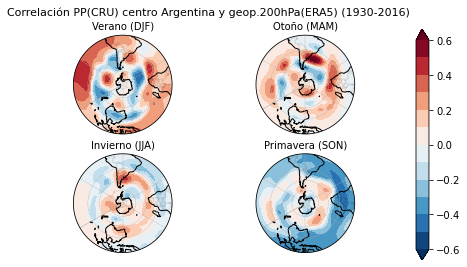

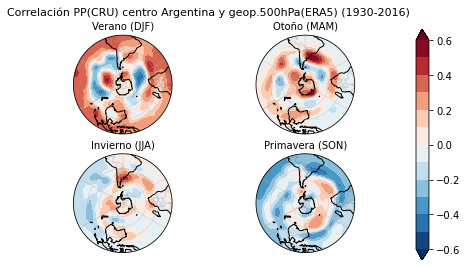

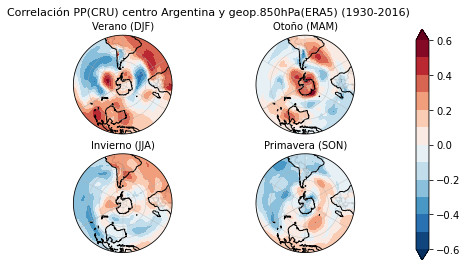

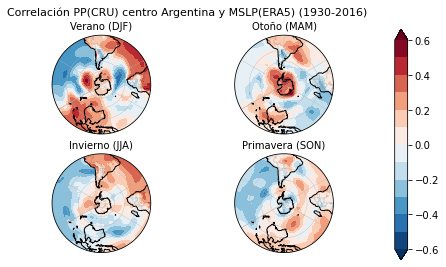

In [15]:
# Precipitación + geopotencial
graf_corrs_stereo(pp_geo200_corr_ST, 'geop.200hPa(ERA5)')
graf_corrs_stereo(pp_geo500_corr_ST, 'geop.500hPa(ERA5)')
graf_corrs_stereo(pp_geo850_corr_ST, 'geop.850hPa(ERA5)')

#Precipitación + presión
graf_corrs_stereo(pp_mslp_corr_ST, 'MSLP(ERA5)')

Figura de correlacion_TSM_PP(CRU)_SinTendencia(1930-2016) en /home/dalia.panza/Proy_IAI/Salidas/


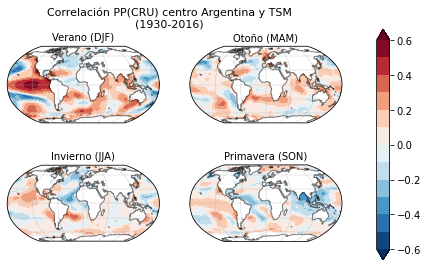

In [16]:
#Precipitación + tsm
graf_corrs_Robinson(pp_tsm_corr_ST, 'TSM')

## Promedio movil de 7 años
Para suprimir la correlación por variabilidad de alta frecuencia, se realizará un promedio móvil de 7 años para cada variable.

In [17]:
pp_anom_est_ST_PromReg_PM7 = moving_average(pp_anom_est_ST_PromReg, 7)
tsm_anom_est_ST_PM7 = moving_average(tsm_anom_est_ST, 7)

In [18]:
geo200_anom_est_ST_PM7 = moving_average(geo200_anom_est_ST, 7)
geo500_anom_est_ST_PM7 = moving_average(geo500_anom_est_ST, 7)
geo850_anom_est_ST_PM7 = moving_average(geo850_anom_est_ST, 7)

In [19]:
mslp_anom_est_ST_PM7 = moving_average(mslp_anom_est_ST, 7)

## Correlación con promedio movil 

In [20]:
#Precipitación + tsm
pp_tsm_corr_ST_PM7 = xr_corr(tsm_anom_est_ST_PM7, pp_anom_est_ST_PromReg_PM7)

In [21]:
#Precipitación + geopotencial
pp_geo200_corr_ST_PM7 = xr_corr(geo200_anom_est_ST_PM7, pp_anom_est_ST_PromReg_PM7)
pp_geo500_corr_ST_PM7 = xr_corr(geo500_anom_est_ST_PM7, pp_anom_est_ST_PromReg_PM7)
pp_geo850_corr_ST_PM7 = xr_corr(geo850_anom_est_ST_PM7, pp_anom_est_ST_PromReg_PM7)

In [22]:
#Precipitación + mslp
pp_mslp_corr_ST_PM7 = xr_corr(mslp_anom_est_ST_PM7, pp_anom_est_ST_PromReg_PM7)

## Mapas mostrando la correlación con promedio móvil


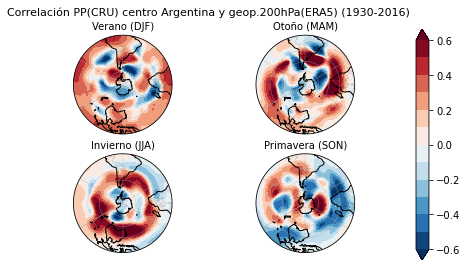

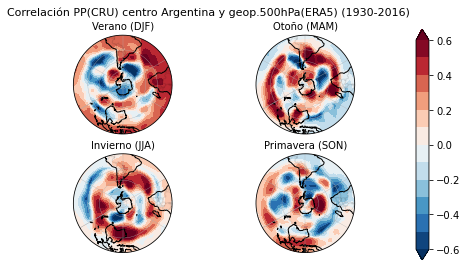

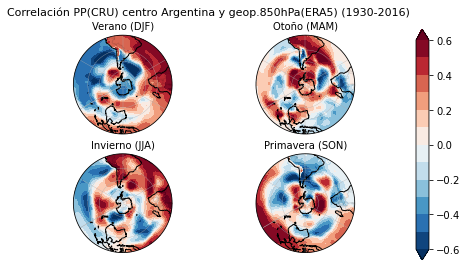

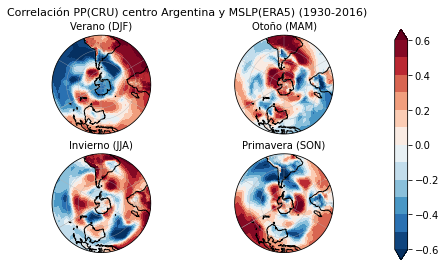

In [23]:
# Precipitación + geopotencial
graf_corrs_stereo(pp_geo200_corr_ST_PM7, 'geop.200hPa(ERA5)')
graf_corrs_stereo(pp_geo500_corr_ST_PM7, 'geop.500hPa(ERA5)')
graf_corrs_stereo(pp_geo850_corr_ST_PM7, 'geop.850hPa(ERA5)')

#Precipitación + presión
graf_corrs_stereo(pp_mslp_corr_ST_PM7, 'MSLP(ERA5)')

Figura de correlacion_TSM_PP(CRU)_SinTendencia(1930-2016) en /home/dalia.panza/Proy_IAI/Salidas/


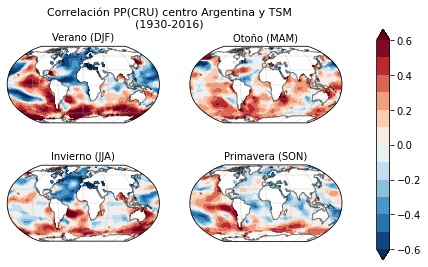

In [24]:
#Precipitación + tsm
graf_corrs_Robinson(pp_tsm_corr_ST_PM7, 'TSM')

## Resultados

### SST
La precipitación en el centro de Argentina y la temperatura en la superficie del mar muestra correlación en:
- Pacífico Norte, puede asociarse a la Oscilación Decadal del Pacífico (PDO). 
- Atlántico Norte (nomeacuerdo)

### MSLP

### Geopotencial 200 hPa

### Geopotencial 500 hPa

### Geopotencial 850 hPa